# 1 サンプルデータの取得・前処理

In [1]:
from tensorflow.keras import utils
utils.set_random_seed(0)

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
datagen = ImageDataGenerator(rescale=1/255, validation_split=0.25)

In [4]:
train_generator = datagen.flow_from_directory(
        '/content/drive/MyDrive/data_train',
        subset='training',
        target_size=(256, 256),
        batch_size=64)

Found 384 images belonging to 2 classes.


In [5]:
train_generator.class_indices

{'cat': 0, 'dog': 1}

In [6]:
val_generator = datagen.flow_from_directory(
        '/content/drive/MyDrive/data_train',
        subset='validation',
        target_size=(256, 256),
        batch_size=64)

Found 128 images belonging to 2 classes.


In [7]:
test_generator = datagen.flow_from_directory(
        '/content/drive/MyDrive/data_test',
        subset='training',
        target_size=(256, 256),
        batch_size=64)

Found 96 images belonging to 2 classes.


# 2 モデルVGG16の準備

In [8]:
from tensorflow.keras.applications.vgg16 import VGG16
vgg16_without_fc = VGG16(weights='imagenet', include_top=False, input_shape=(256,256,3))

58889256/58889256 [==============================] - 1s 0us/step


In [9]:
from tensorflow.keras.models import Sequential
model = Sequential()
for layer in vgg16_without_fc.layers:
    model.add(layer)

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 64, 64, 256)       2

In [11]:
for layer in model.layers:
    layer.trainable = False

In [12]:
from tensorflow.keras.layers import Flatten, Dense

In [13]:
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='softmax'))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 64, 64, 256)       2

# 3 パラメータの最適化

In [15]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics='accuracy')

In [16]:
history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=5)

Epoch 1/5
6/6 [==============================] - 66s 8s/step - loss: 3.3933 - accuracy: 0.5286 - val_loss: 1.6558 - val_accuracy: 0.5078
Epoch 2/5
6/6 [==============================] - 6s 961ms/step - loss: 0.7937 - accuracy: 0.7578 - val_loss: 0.5137 - val_accuracy: 0.9062
Epoch 3/5
6/6 [==============================] - 4s 655ms/step - loss: 0.3952 - accuracy: 0.9167 - val_loss: 0.2417 - val_accuracy: 0.8984
Epoch 4/5
6/6 [==============================] - 4s 650ms/step - loss: 0.2119 - accuracy: 0.9479 - val_loss: 0.2427 - val_accuracy: 0.9297
Epoch 5/5
6/6 [==============================] - 6s 984ms/step - loss: 0.1172 - accuracy: 0.9766 - val_loss: 0.1854 - val_accuracy: 0.9297


# 4 学習結果の可視化

<Axes: >

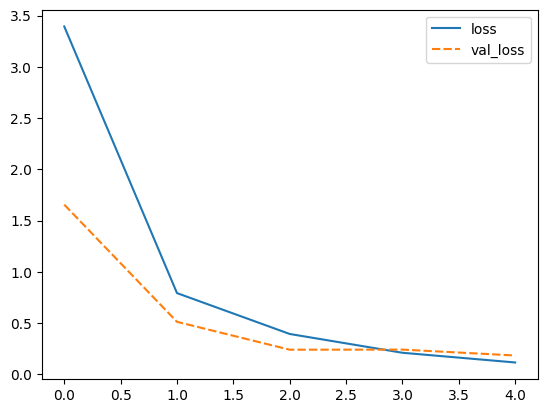

In [17]:
import pandas as pd
import seaborn as sns
df = pd.DataFrame(history.history)
sns.lineplot(data=df[['loss', 'val_loss']])

<Axes: >

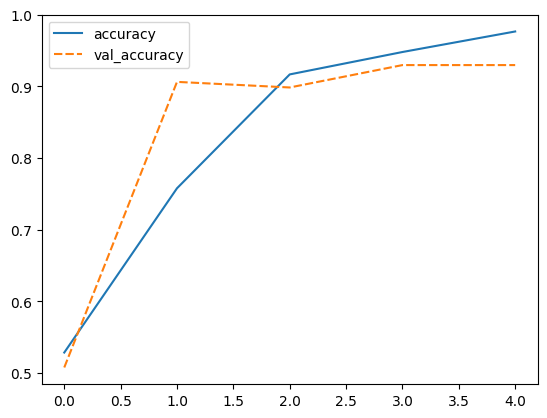

In [18]:
sns.lineplot(data=df[['accuracy', 'val_accuracy']])

# 5 評価

In [25]:
model.evaluate(test_generator)

2/2 [==============================] - 15s 14s/step - loss: 0.3171 - accuracy: 0.8333


[0.3170784115791321, 0.8333333134651184]

# 6 予測

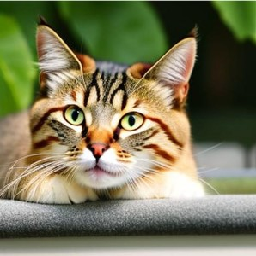

In [20]:
from tensorflow.keras.preprocessing.image import load_img
unknown_img = load_img('unknown_cat.jpg', target_size=(256, 256))
unknown_img

In [21]:
from tensorflow.keras.preprocessing.image import img_to_array
unknown_array = img_to_array(unknown_img)
unknown_array = unknown_array.reshape((1, 256, 256, 3))
unknown_array = unknown_array/255

In [22]:
model.predict(unknown_array)

1/1 [==============================] - 1s 1s/step


array([[1.000000e+00, 4.625467e-09]], dtype=float32)

# 7 予測モデルの保存

In [27]:
from tensorflow.keras.models import save_model

In [28]:
save_model(model, 'model.h5')

<ipython-input-28-242b5aa1d1a5>:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, 'model.h5')


# 8 予測モデルの読み込み

In [29]:
from tensorflow.keras.models import load_model
loaded_model = load_model('model.h5')

In [30]:
loaded_model.predict(unknown_array)

1/1 [==============================] - 0s 281ms/step


array([[1.000000e+00, 4.625467e-09]], dtype=float32)